<a href="https://colab.research.google.com/github/srihitha2006/ACM-club-work/blob/main/malicious_url_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving malicious_phish.csv to malicious_phish.csv


In [2]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # Fixed the typo
import xgboost as xgb
from lightgbm import LGBMClassifier  # Fixed the incorrect import
import os
import seaborn as sns
from wordcloud import WordCloud


In [3]:
pip install dask

In [4]:
df=pd.read_csv('malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df.type.value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


### **plotting Wordcloud**

In [6]:
df_phish = df[df['type'] == 'phishing']
df_malware = df[df['type'] == 'malware']
df_deface= df[df['type'] == 'defacement']
df_benign = df[df['type'] == 'benign']

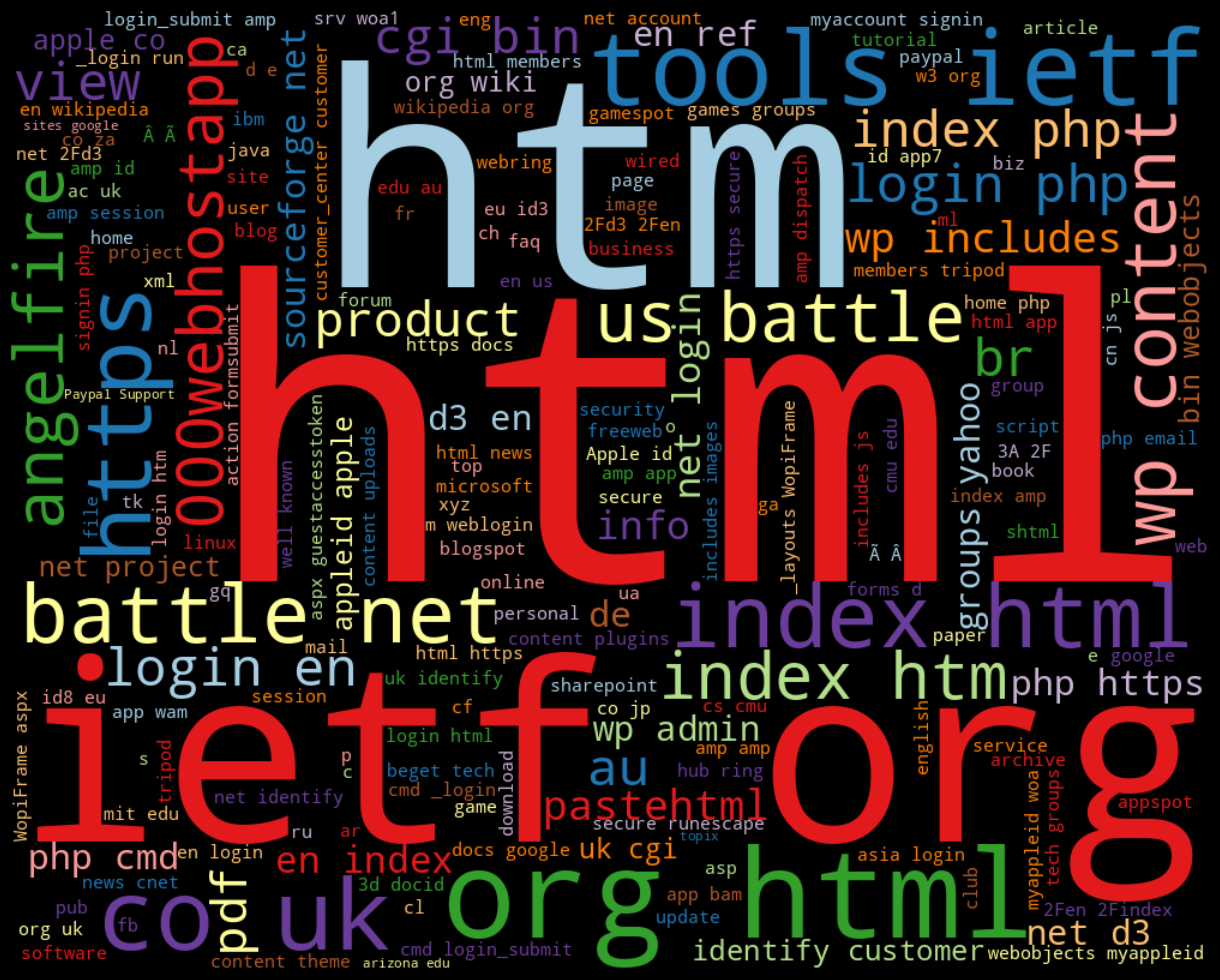

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df_phish is a pandas DataFrame containing a column 'url'
phish_url = " ".join(i for i in df_phish.url)

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=800, colormap="Paired").generate(phish_url)

# Plot the word cloud
plt.figure(figsize=(12, 14), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

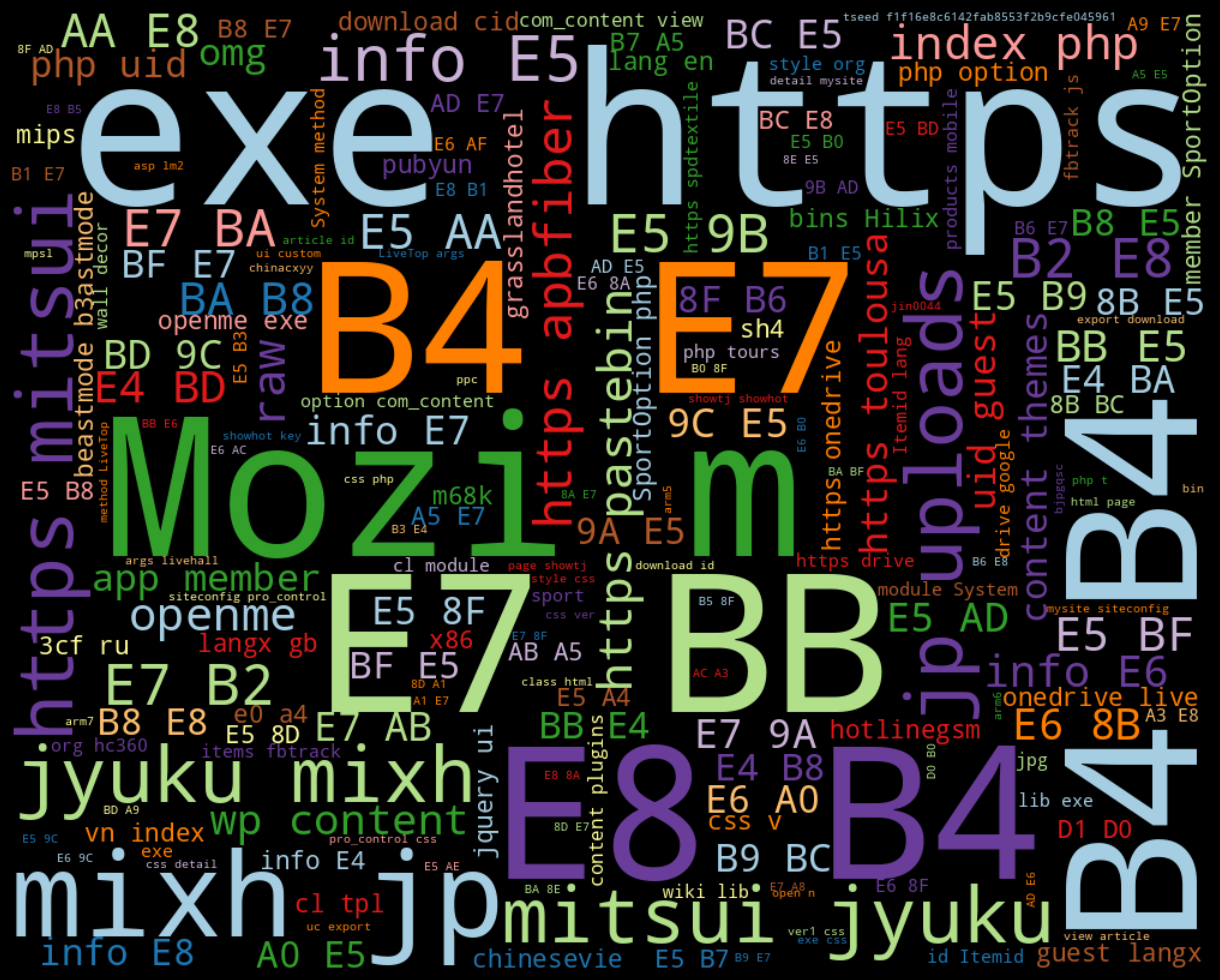

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df_malware is a pandas DataFrame containing a column 'url'
malware_url = " ".join(i for i in df_malware.url)

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=800, colormap="Paired").generate(malware_url)

# Plot the word cloud
plt.figure(figsize=(12, 14), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

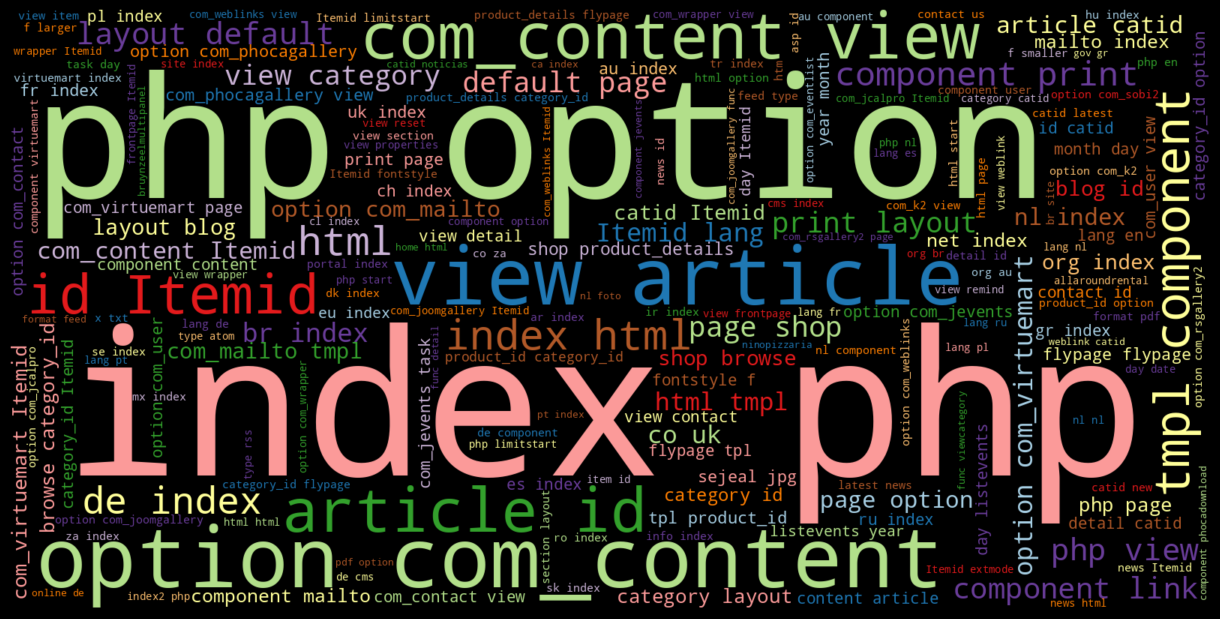

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df_deface is a pandas DataFrame containing a column 'url'
deface_url = " ".join(i for i in df_deface.url)

# Generate the word cloud
wordcloud = WordCloud(width=1600, height=800, colormap="Paired").generate(deface_url)

# Plot the word cloud
plt.figure(figsize=(12, 14), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

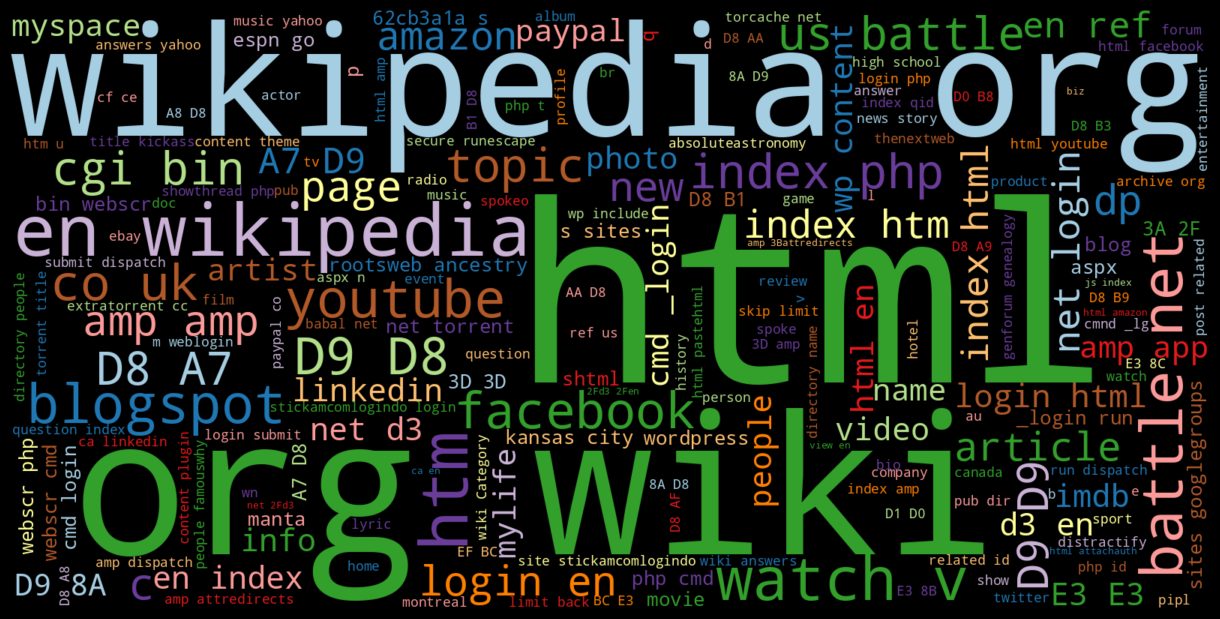

In [10]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(benign_url)

plt.figure(figsize=(12, 14), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


## Feature Engineering

In [11]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.'
        '(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)'
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url
    )
    if match:
        return 1
    else:
        return 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [12]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)

    if match:
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [13]:
pip install googlesearch-python

In [14]:
from googlesearch import search

In [15]:
def google_index(url):
  site = search(url, 5)
  return 1 if site else 0

df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [16]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [17]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):

    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))

def shortening_service(url):
    match = re.search(
        'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
        'yfrog\.com|migre\.me|ff\.im|imj\.in|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
        'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
        'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
        'db\.tt|qr\.ae|adf\.ly|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
        'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
        'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|url\.ie|tweez\.me|v\.gd',
        url
    )

    if match:
        return 1
    else:
        return 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))


In [18]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i: count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i: count_http(i))

In [20]:
def count_per(url):
  return url.count('%')

df['count%'] = df['url'].apply(lambda i: count_per(i))

def count_ques(url):
  return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
  return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
  return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
  return len(url)

df['url_length'] = df['url'].apply(lambda i: url_length(i))


def suspicious_words(url):
  match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                    url)
  if match:
    return 1
  else:
    return 0

df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

def digit_count(url):
  digits = 0
  for i in url:
    if i.isnumeric():
      digits = digits + 1
  return digits

df['count-digits']= df['url'].apply(lambda i: digit_count(i))

def letter_count(url):
  letters = 0
  for i in url:
    if i.isalpha():
      letters = letters + 1
  return letters

df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-https,count-http,count%,count?,count-,count=,url_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,0,1,0,16,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,0,35,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,0,31,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,0,1,0,1,1,4,88,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,0,1,0,1,1,3,235,0,22,199


In [21]:
pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 5.8 MB/s eta 0:00:00


In [25]:
from urllib.parse import urlparse
from tld import get_tld
import os.path

def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

# Fix: Remove fail_silent argument and handle exceptions instead
def get_tld_wrapper(url):
    try:
        return get_tld(url)
    except:
        return None  # or any other default value you prefer

df['tld'] = df['url'].apply(get_tld_wrapper)

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [26]:
df = df.drop("tld", axis=1)
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'sus_url', 'count-digits', 'count-letters', 'fd_length',
       'tld_length'],
      dtype='object')

In [27]:
df['type'].value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


## Distribution of use_of_ip

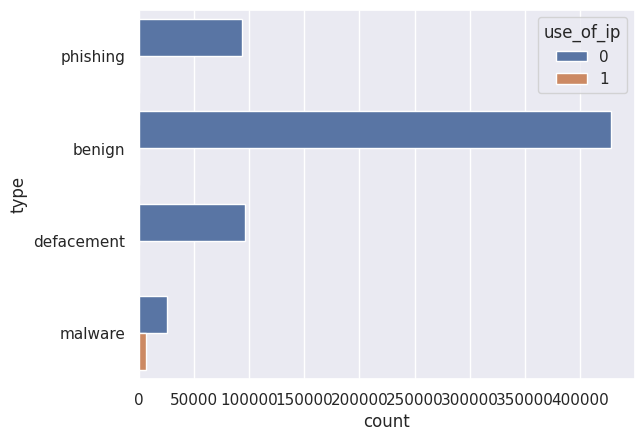

In [30]:
import seaborn as sns
sns.set(style="darkgrid")
ax=sns.countplot(y='type', data=df,hue='use_of_ip')

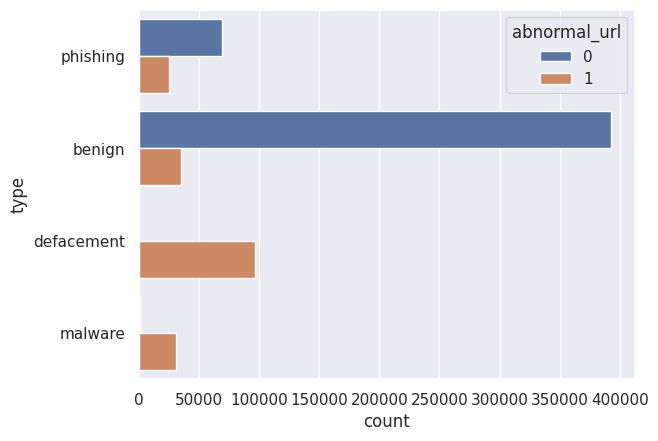

In [32]:
sns.set(style="darkgrid")
ax=sns.countplot(y='type', data=df,hue='abnormal_url')

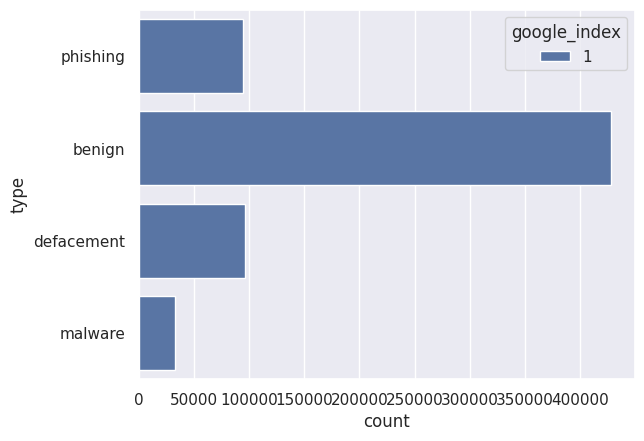

In [33]:
sns.set(style="darkgrid")
ax=sns.countplot(y='type', data=df,hue='google_index')

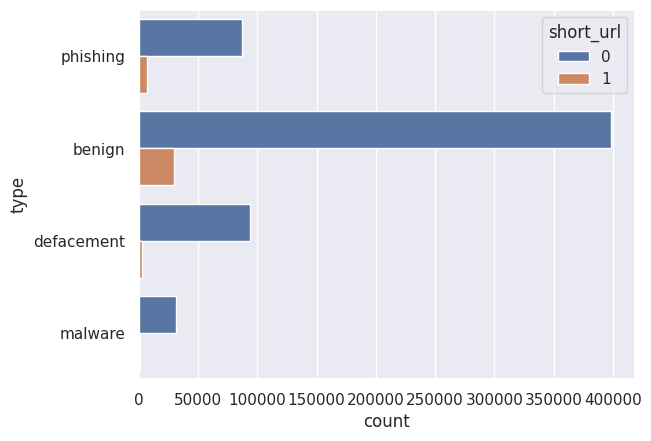

In [34]:
sns.set(style="darkgrid")
ax=sns.countplot(y='type', data=df,hue='short_url')

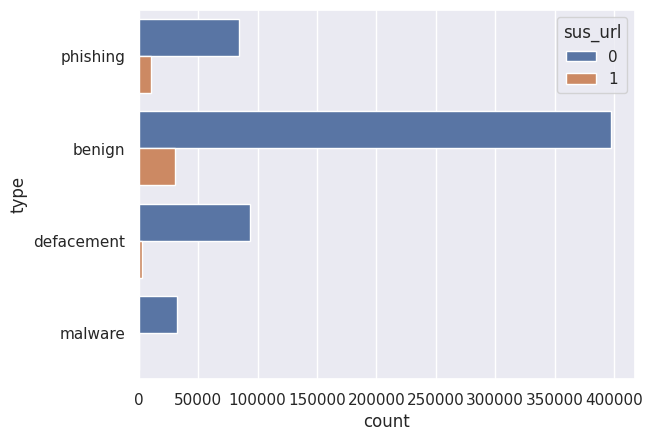

In [35]:
sns.set(style="darkgrid")
ax=sns.countplot(y='type', data=df,hue='sus_url')

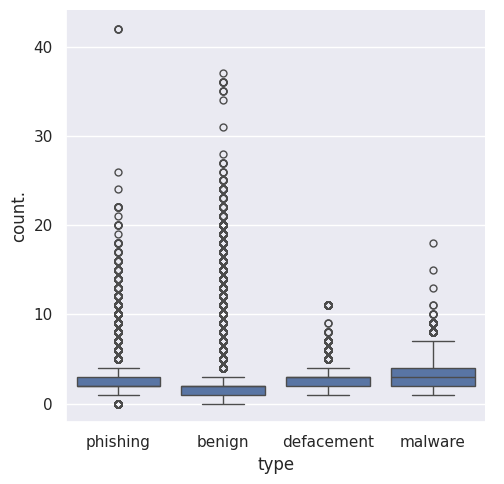

In [38]:
sns.set(style="darkgrid")
ax=sns.catplot(x='type',y="count.",kind="box",data=df)

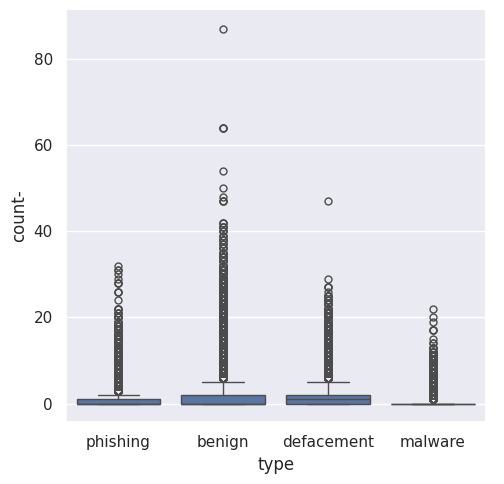

In [39]:
sns.set(style="darkgrid")
ax=sns.catplot(x='type',y="count-",kind="box",data=df)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)


In [45]:
# 1. Prepare your data for modeling
# Assuming 'type' is your target variable and you want to drop 'url'
X = df.drop(['type', 'url'], axis=1)  # Drop the 'url' column
y = df['type']

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # Adjust test_size and random_state as needed

# 3. Train a RandomForest model (replace with your desired model)
rf_model = RandomForestClassifier(random_state=42)  # Adjust hyperparameters as needed
rf_model.fit(X_train, y_train)

# 4. Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

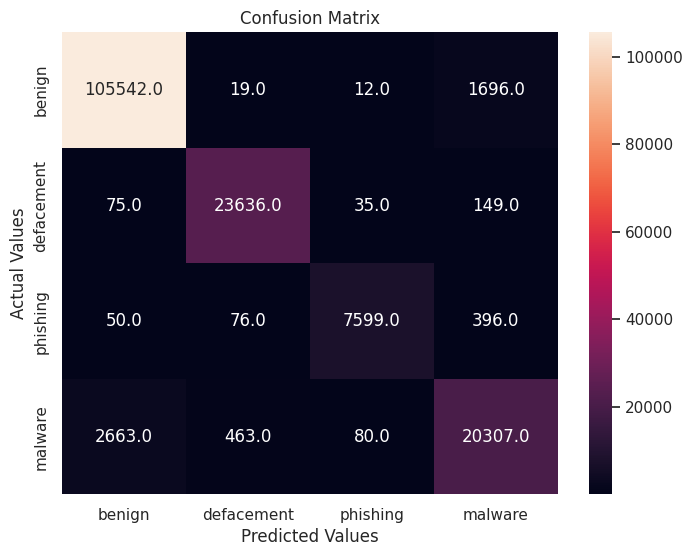

In [46]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
    index=['benign', 'defacement', 'phishing', 'malware'],
    columns=['benign', 'defacement', 'phishing', 'malware'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


In [47]:
def main(url):
    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))

    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))

    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))

    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))

    tld = get_tld(url, fail_silently=True)
    status.append(tld_length(tld))

    return status


In [55]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)

    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    pred = lgb.predict(features_test)

    if int(pred[0]) == 0:
        res = "SAFE"
        return res
    elif int(pred[0]) == 1:
        res = "DEFACEMENT"
        return res
    elif int(pred[0]) == 2:
        res = "PHISHING"
        return res
    elif int(pred[0]) == 3:
        res = "MALWARE"
        return res
